Instalando Pacotes

In [ ]:
!pip install gym==0.24
!pip install imageio
!pip install imageio_ffmpeg
!pip install pyglet==1.5.1
!pip install tqdm
!pip install pygame

In [ ]:
import gym
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from collections import deque
import time
import random

from IPython import display
from IPython.display import HTML
import pygame
from base64 import b64encode
import matplotlib.pyplot as plt
import imageio
from time import sleep
import tqdm
from tqdm.notebook import tqdm
import os

In [ ]:
%%capture
!apt update
!apt install ffmpeg xvfb
!pip install xvfbwrapper
!pip install pyvirtualdisplay

In [ ]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

## Inicializa o Enviroment

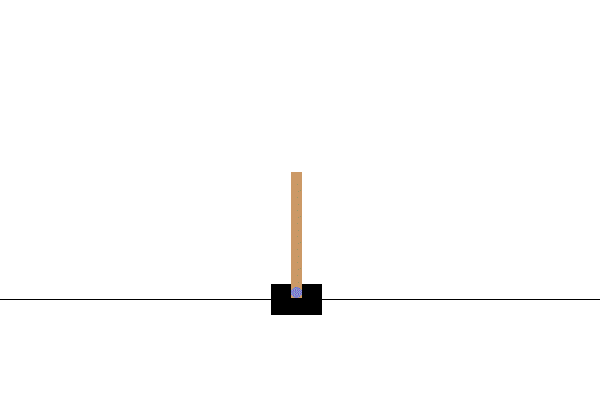

In [ ]:
env = gym.make('CartPole-v1')
env.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

1. **Tipo de Espaço:**
   - **Box**: Indica que o espaço de observação é contínuo. Cada componente do vetor de estado pode assumir qualquer valor dentro dos limites especificados.

2. **Limites Inferiores e Superiores:**
   - **Limites inferiores**: `[-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38]`
   - **Limites superiores**: `[4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38]`
   - Esses limites correspondem aos valores mínimos e máximos que cada componente do vetor de estado pode assumir.

3. **Dimensões do Espaço:**
   - **(4,)**: Indica que o vetor de estado tem 4 dimensões. Portanto, cada estado observado é um vetor com 4 componentes.

4. **Tipo de Dados:**
   - **float32**: Indica que os valores no vetor de estado são de ponto flutuante de 32 bits.

### Componentes do Vetor de Estado

Para o ambiente CartPole, o vetor de estado geralmente contém as seguintes componentes:

1. **Posição do Carrinho (cart position)**: Quanto o carrinho se deslocou da posição central (pode variar entre -4.8 e 4.8).
2. **Velocidade do Carrinho (cart velocity)**: Velocidade com a qual o carrinho está se movendo (não há limites específicos fornecidos no ambiente padrão, por isso valores muito grandes são usados como limites).
3. **Ângulo do Pêndulo (pole angle)**: Ângulo do pêndulo em relação à vertical (pode variar entre aproximadamente -0.418 radianos e 0.418 radianos, cerca de ±24 graus).
4. **Velocidade Angular do Pêndulo (pole angular velocity)**: Velocidade com a qual o pêndulo está girando (sem limites específicos fornecidos, daí os valores extremos).

In [ ]:
# Parâmetros do Modelo
num_actions = env.action_space.n
num_states = env.observation_space.shape[0]
learning_rate = 0.01

Criação do modelo de política

In [ ]:
# Criação do modelo de política
def create_policy_model():
    model = tf.keras.Sequential([
        layers.Dense(24, activation='relu', input_shape=(num_states,)),
        layers.Dense(24, activation='relu'),
        layers.Dense(num_actions, activation='softmax')
    ])
    return model

In [ ]:
# Função para obter uma ação com base na política atual
def get_action(state):
    state = state.reshape([1, num_states])
    probabilities = policy_model(state)
    action = np.random.choice(num_actions, p=np.squeeze(probabilities))
    return action

In [ ]:
# Função para calcular o retorno descontado
def compute_returns(rewards, gamma=0.99):
    returns = np.zeros_like(rewards)
    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns

In [ ]:
policy_model = create_policy_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Rotina de Treino

In [ ]:
# Treinamento do Modelo
def train(env, policy_model, optimizer, num_episodes=1000, gamma=0.99):
    all_returns = []

    for episode in range(num_episodes):
        state = env.reset()  # Reinicia o ambiente no início de cada episódio
        episode_states = []
        episode_actions = []
        episode_rewards = []

        done = False
        while not done:
            action = get_action(state)  # Seleciona uma ação com base na política atual
            next_state, reward, done, _ = env.step(action)  # Executa a ação no ambiente
            episode_states.append(state)  # Armazena o estado atual
            episode_actions.append(action)  # Armazena a ação tomada
            episode_rewards.append(reward)  # Armazena a recompensa recebida
            state = next_state  # Atualiza o estado atual

        episode_returns = compute_returns(episode_rewards, gamma)  # Calcula os retornos descontados
        all_returns.append(sum(episode_rewards))  # Armazena o total de recompensas do episódio

        episode_states = np.array(episode_states)
        episode_actions = np.array(episode_actions)
        episode_returns = np.array(episode_returns)

        with tf.GradientTape() as tape:
            # Calcula as probabilidades das ações para cada estado no episódio
            action_probs = policy_model(episode_states, training=True)
            # Índices para ações tomadas
            indices = np.array([np.arange(len(episode_actions)), episode_actions]).T
            # Obtém as probabilidades das ações realmente tomadas
            action_probs = tf.gather_nd(action_probs, indices)
            # Calcula a perda como o negativo da média do log das probabilidades ponderadas pelos retornos
            loss = -tf.reduce_mean(tf.math.log(action_probs) * episode_returns)

        grads = tape.gradient(loss, policy_model.trainable_variables)  # Calcula os gradientes
        optimizer.apply_gradients(zip(grads, policy_model.trainable_variables))  # Aplica os gradientes para atualizar a política

        if episode % 50 == 0:
            total_rewards = sum(episode_rewards)
            print(f"Episode {episode}: Total Reward: {total_rewards}")  # Exibe o total de recompensas a cada 50 episódios
            if total_rewards== 500:
                break

    return all_returns


Definição dos parâmetros

In [ ]:
# Executando o treinamento
num_episodes = 2000
returns = train(env, policy_model, optimizer, num_episodes)

Episode 0: Total Reward: 15.0
Episode 50: Total Reward: 19.0
Episode 100: Total Reward: 10.0
Episode 150: Total Reward: 10.0
Episode 200: Total Reward: 11.0
Episode 250: Total Reward: 13.0
Episode 300: Total Reward: 9.0
Episode 350: Total Reward: 9.0
Episode 400: Total Reward: 10.0
Episode 450: Total Reward: 9.0
Episode 500: Total Reward: 9.0
Episode 550: Total Reward: 9.0
Episode 600: Total Reward: 23.0
Episode 650: Total Reward: 29.0
Episode 700: Total Reward: 10.0
Episode 750: Total Reward: 25.0
Episode 800: Total Reward: 215.0
Episode 850: Total Reward: 221.0
Episode 900: Total Reward: 16.0
Episode 950: Total Reward: 500.0


# Processo de Teste da Política

In [ ]:
total_test_rewards = 0
observation = env.reset()
images = []
done = False
i = 0
max_steps = 1000
render = True
while not done:
    i += 1
    if i > max_steps:
      break

    if render:
        img = env.render(mode='rgb_array')
        images.append(img)


    encoded = observation
    encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
    predicted = policy_model.predict(encoded_reshaped).flatten()
    action = np.argmax(predicted)
    new_observation, reward, done, info = env.step(action)

    observation = new_observation
    total_test_rewards += reward

    if done:
        print('Total test rewards: {}'.format(total_test_rewards))
        total_test_rewards += 1

env.close()

1/1 [==============================] - 0s 25ms/step
Total test rewards: 500.0


In [ ]:
pygame.quit()

In [ ]:
def play_episode(images, video_path):
  kargs = { 'macro_block_size': 1 }
  imageio.mimsave(video_path, [np.array(img) for i, img in enumerate(images)], fps=15, **kargs)


In [ ]:
video_path = "replay.mp4"
play_episode(images, video_path)
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
